# Ann Arbor Network


#### Mallets Network
![Network](./AA_network.png "Mallet Subcatch")

Reproduce the control experiment to see if bayesian optimization can match the performance of reinforcemnet learning controller.

We control ponds 1,2,3,4 with the objective of maintaining the flows below a threshold with out flooding (similar objective was achived in the RL paper).

In [16]:
# Import the necessary library 
## Plotting Libraries 
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.print_figure_kwargs = {}
import seaborn as sns
import scipy.signal as spy
import scipy
sns.set_style("whitegrid")

## Pyswmm engine with ICC 
from pyswmm_lite import Env

## Bayesian Optimization
import numpy as np
from GPyOpt.methods import BayesianOptimization
import tslearn.metrics as ts
import copy

## Dynamic Time Warping (DTW)

Let us consider two signals shifted in time (i.e a phase difference)

<IPython.core.display.Javascript object>


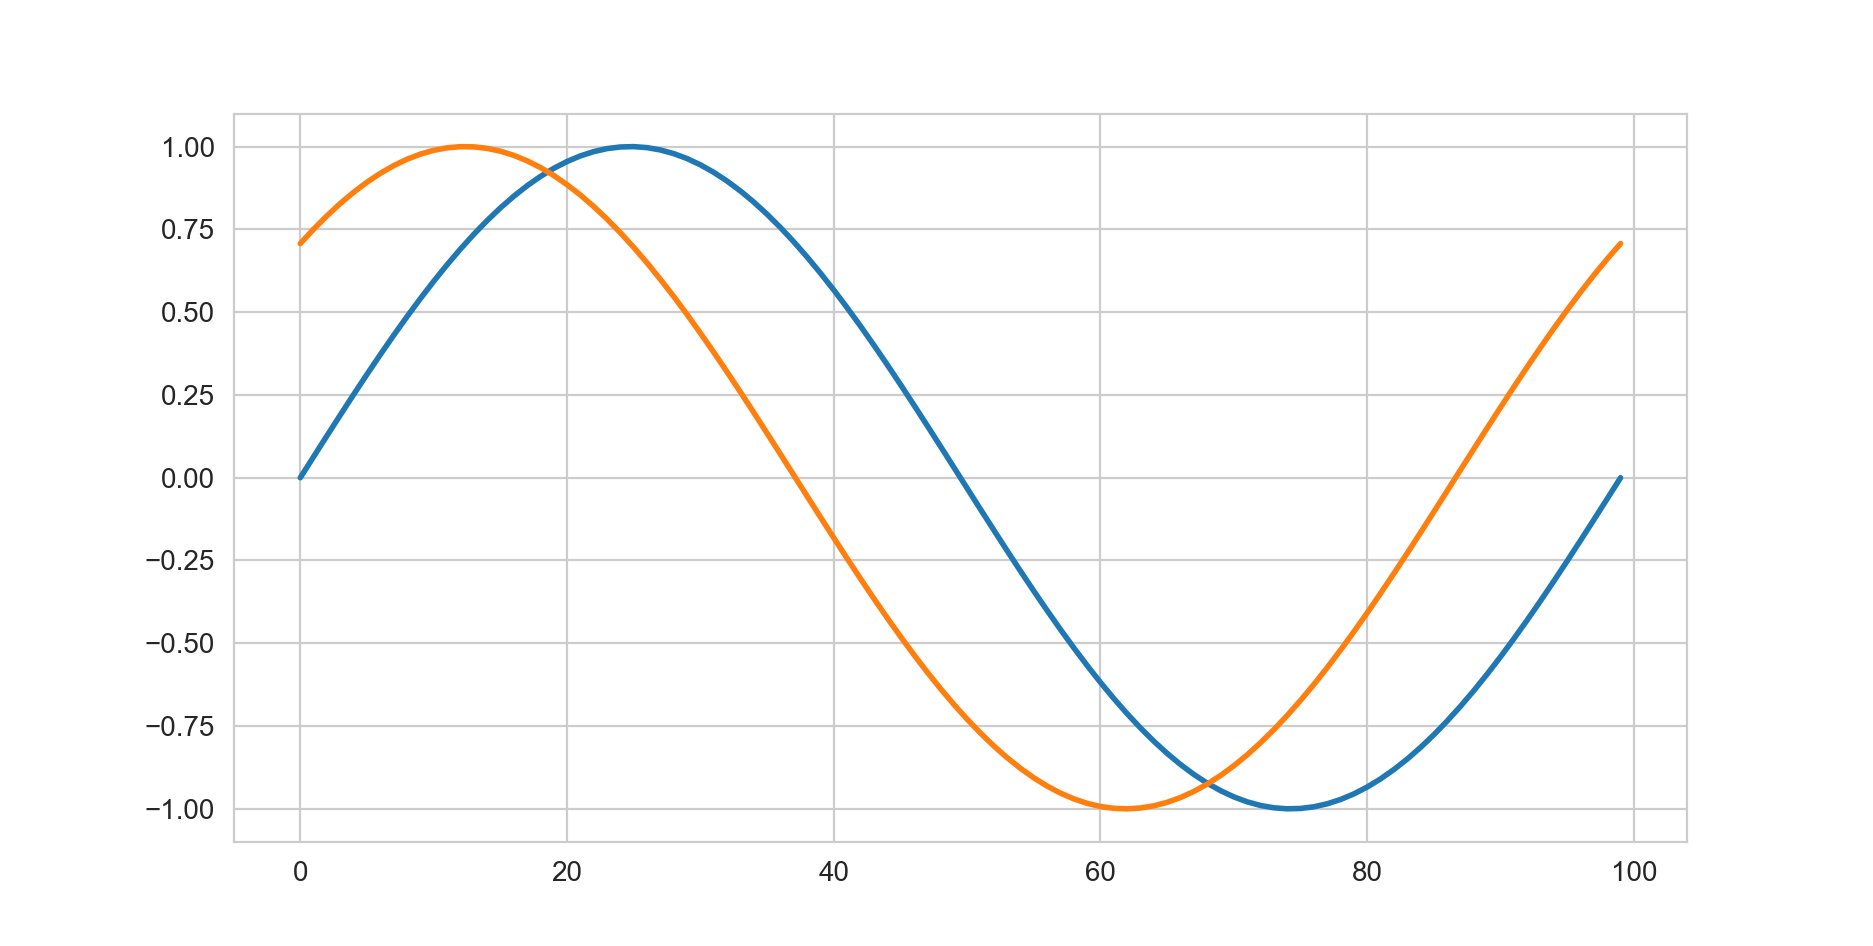

In [18]:
signal1 = np.sin(np.linspace(0, 2, 100) * np.pi)
signal2 = np.sin(np.linspace(0.25, 2.25, 100) * np.pi)
plt.plot(signal1, linewidth=2.0)
plt.plot(signal2, linewidth=2.0)

**DTW** computes the relative distance between two signals as illustrated in the plot below.

<IPython.core.display.Javascript object>


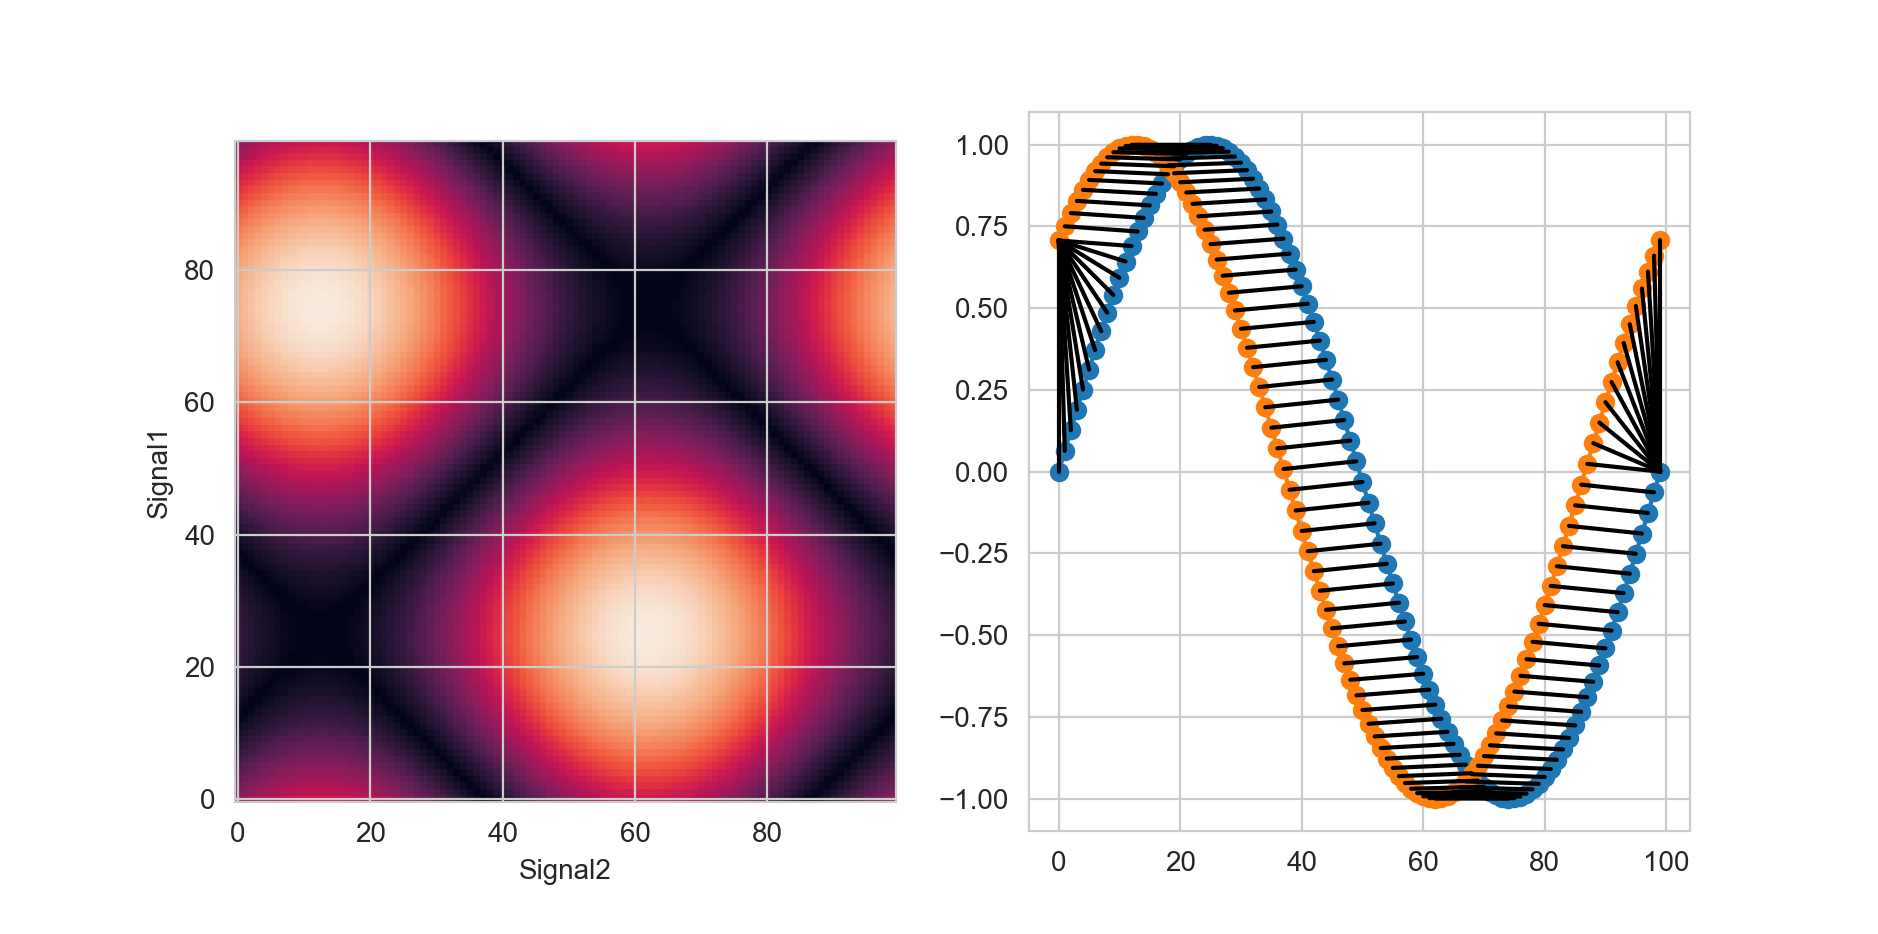

Text(0, 0.5, 'Signal1')

In [17]:
plt.subplot(1,2,2)
path, distance = ts.dtw_path(signal1, signal2)
plt.plot(signal1, "o-", label="Original Signal")
plt.plot(signal2, "o-", label="Shifted Signal")
for i in path:
    plt.plot([i[0], i[1]], [signal1[i[0]], signal2[i[1]]], 'k')
    
plt.subplot(1,2,1)
mat = scipy.spatial.distance.cdist(signal1.reshape(100,1), signal2.reshape(100,1))
plt.imshow(mat, origin="lower")
plt.xlabel("Signal2")
plt.ylabel("Signal1")

### Why warping ?
So this begs the question on why would you need a new metric to optimize the timeseries ?, why not just use euclidian distance ?

So let us compute the euclidian distance for time shifted signals

<IPython.core.display.Javascript object>


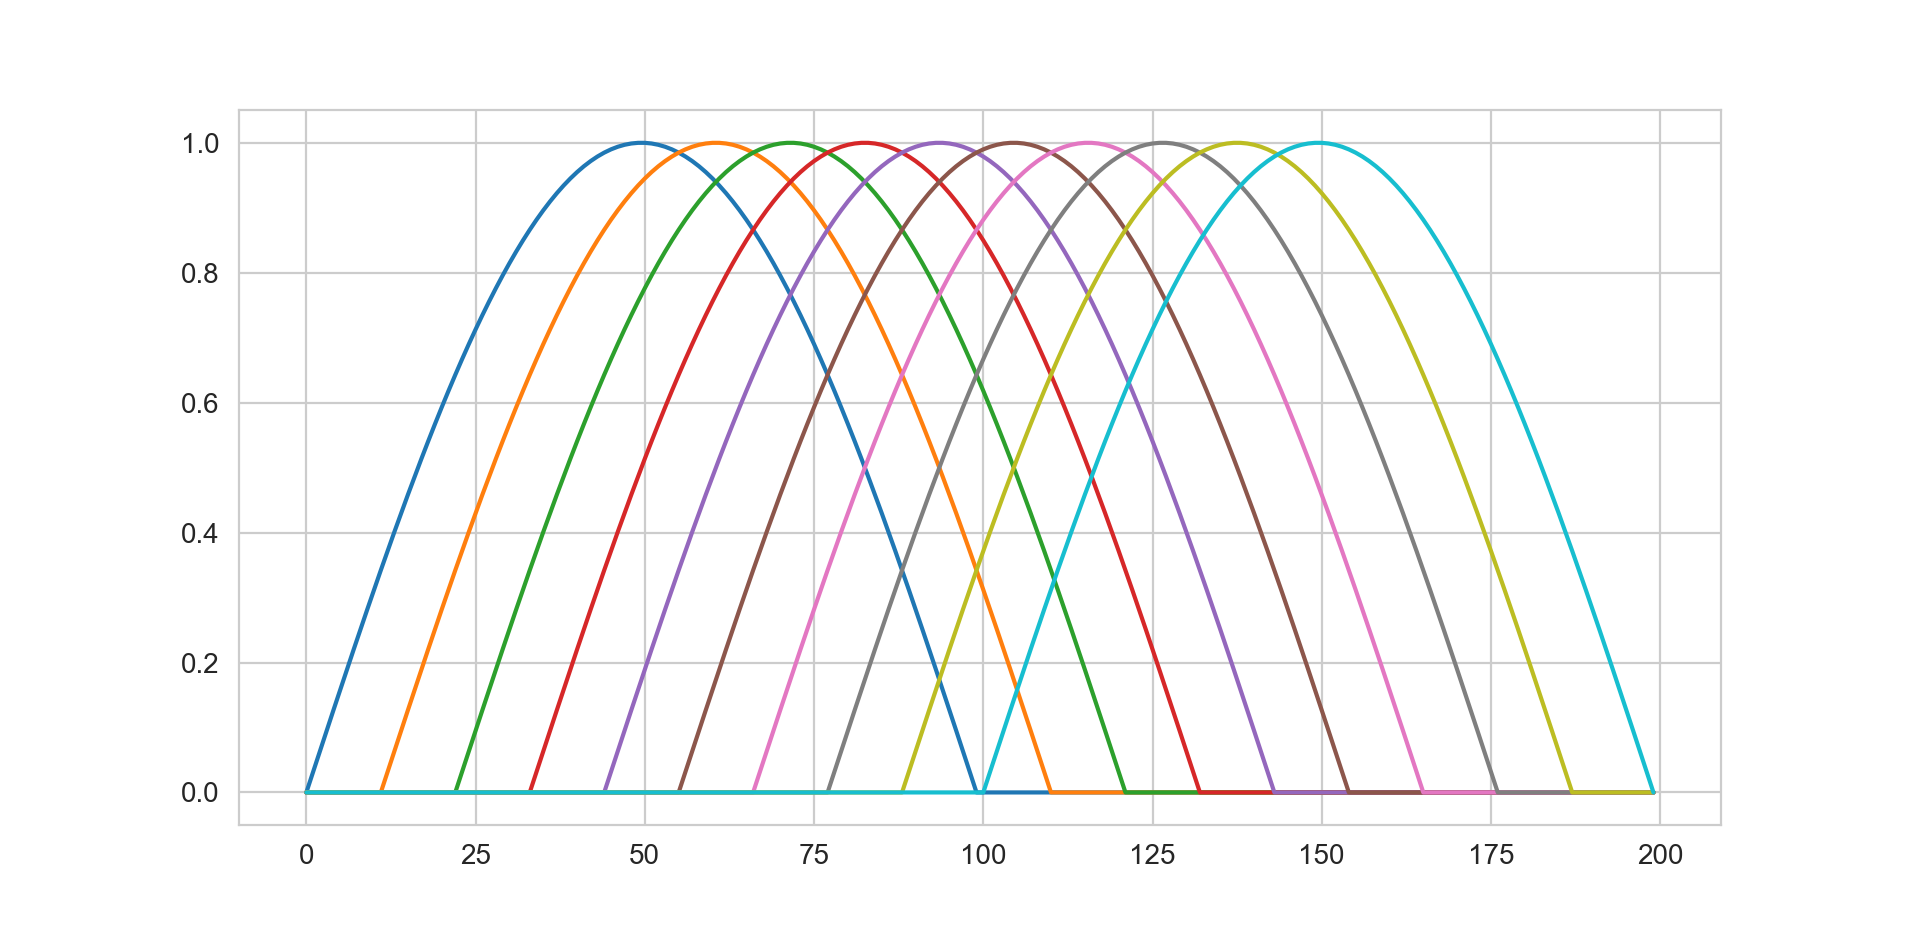

In [19]:
sines = [np.hstack((np.zeros(i),np.sin(np.linspace(0, 1, 100)*np.pi), np.zeros(100-i))) for i in np.linspace(0, 100, 10, dtype=int)]

for i in sines:
    plt.plot(i)

<IPython.core.display.Javascript object>


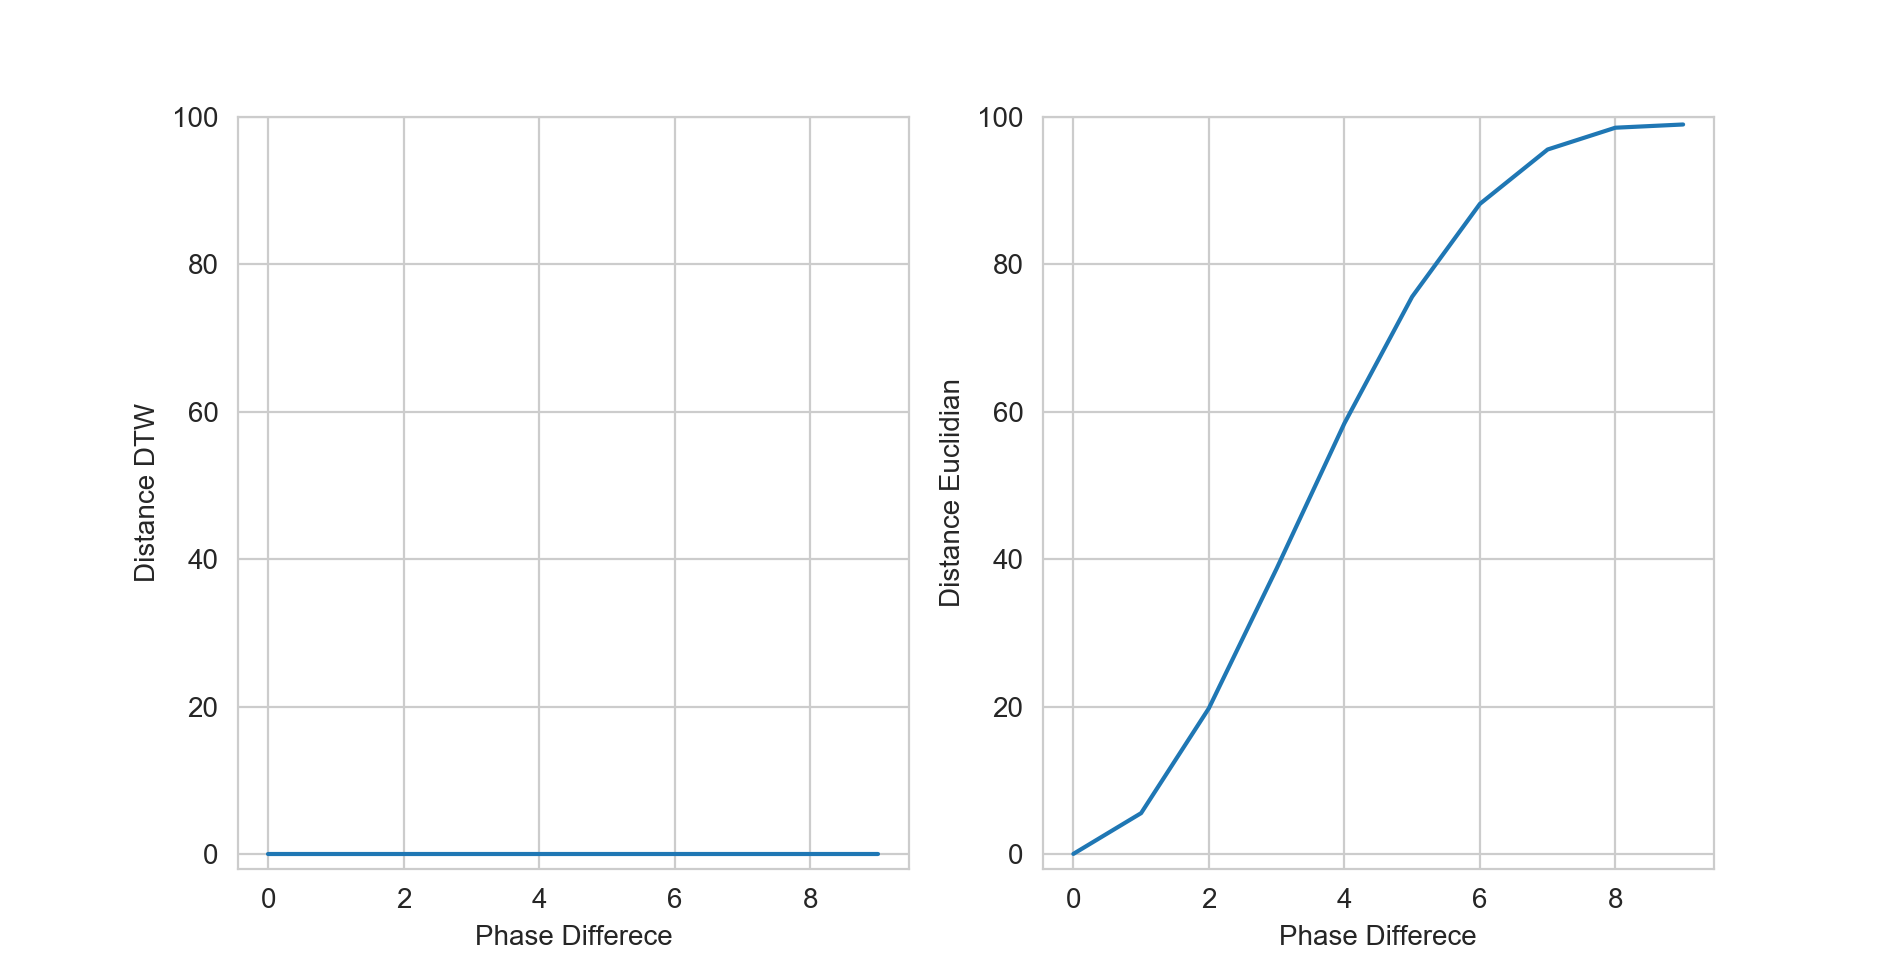

(-2, 100)

In [20]:
paths = []
distances_dtw = []
distances_euc = []

for i in sines:
    p, d = ts.dtw_path(sines[0], i)
    paths.append(p)
    distances_dtw.append(d)
    distances_euc.append((sines[0] - i).T @ (sines[0] - i))
    
plt.subplot(1,2,1)
plt.plot(distances_dtw)
plt.xlabel("Phase Differece")
plt.ylabel("Distance DTW")
plt.ylim([-2, 100])

plt.subplot(1,2,2)
plt.plot(distances_euc)
plt.xlabel("Phase Differece")
plt.ylabel("Distance Euclidian")
plt.ylim([-2, 100])

As you can see that DTW is robust to the linear shift time, while euclidean distance essentially treats any diviation as a anamoly.

<IPython.core.display.Javascript object>


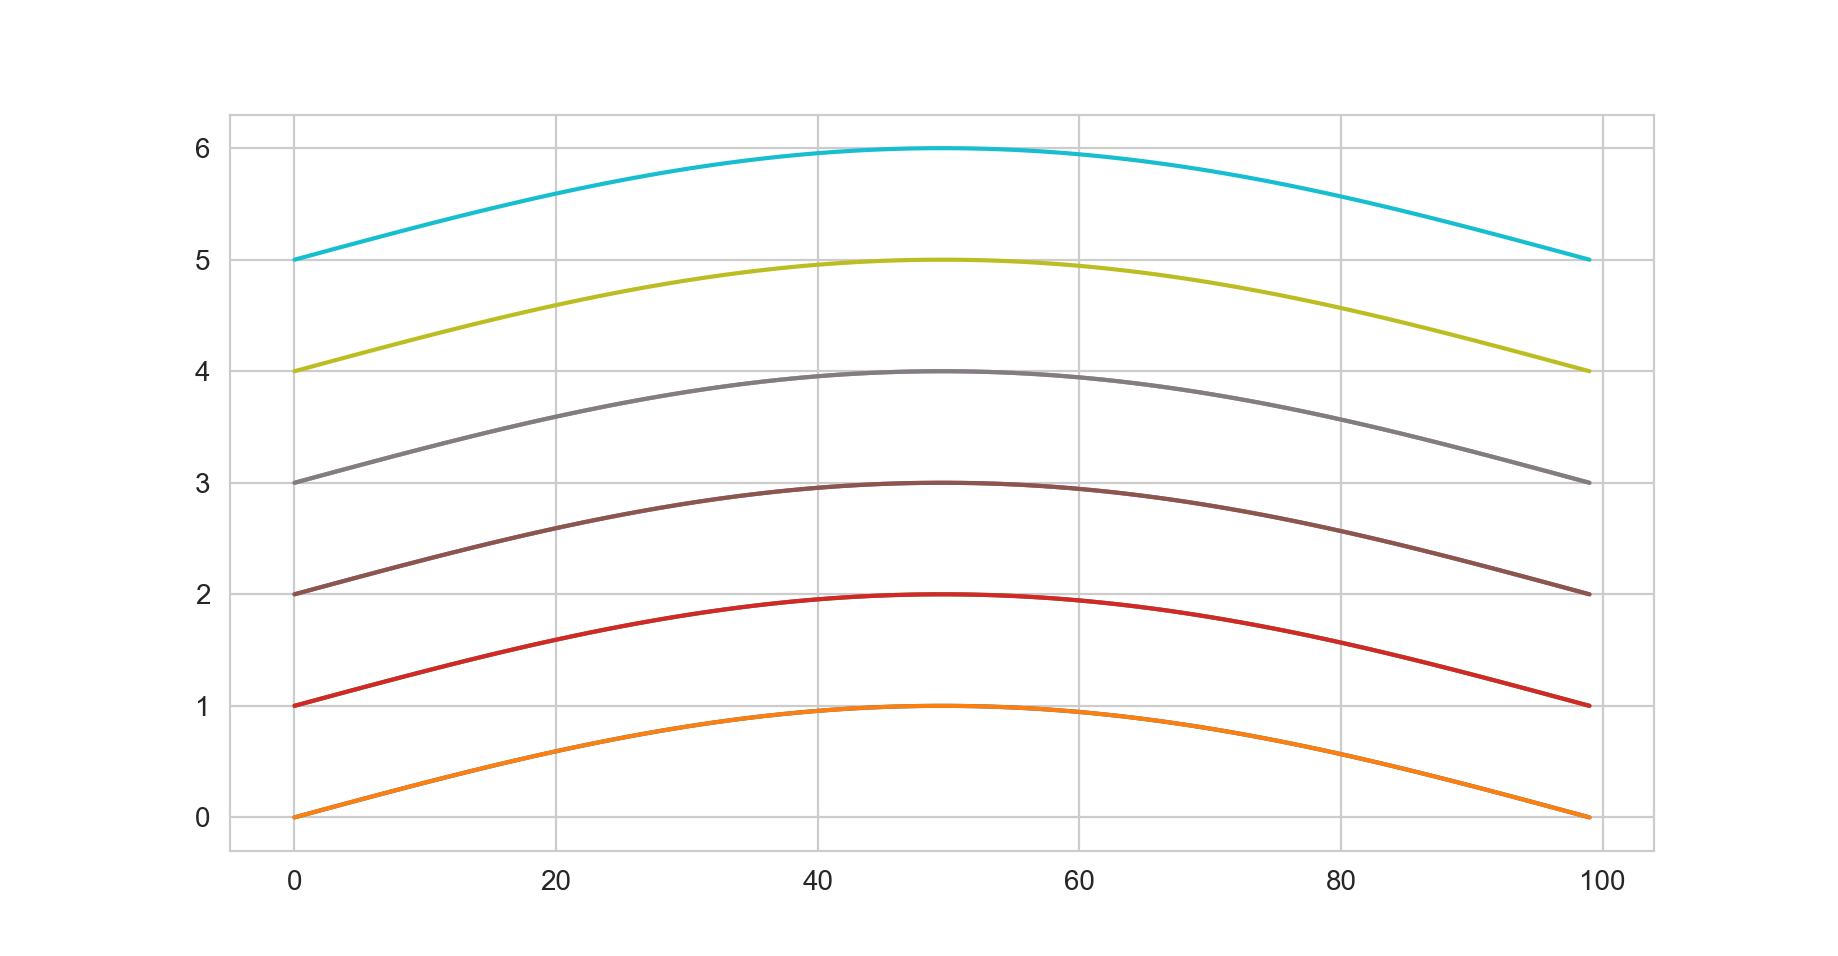

In [21]:
sines = [i + np.sin(np.linspace(0, 1, 100)*np.pi) for i in np.linspace(0, 5, 10, dtype=int)]
for i in sines:
    plt.plot(i)

<IPython.core.display.Javascript object>


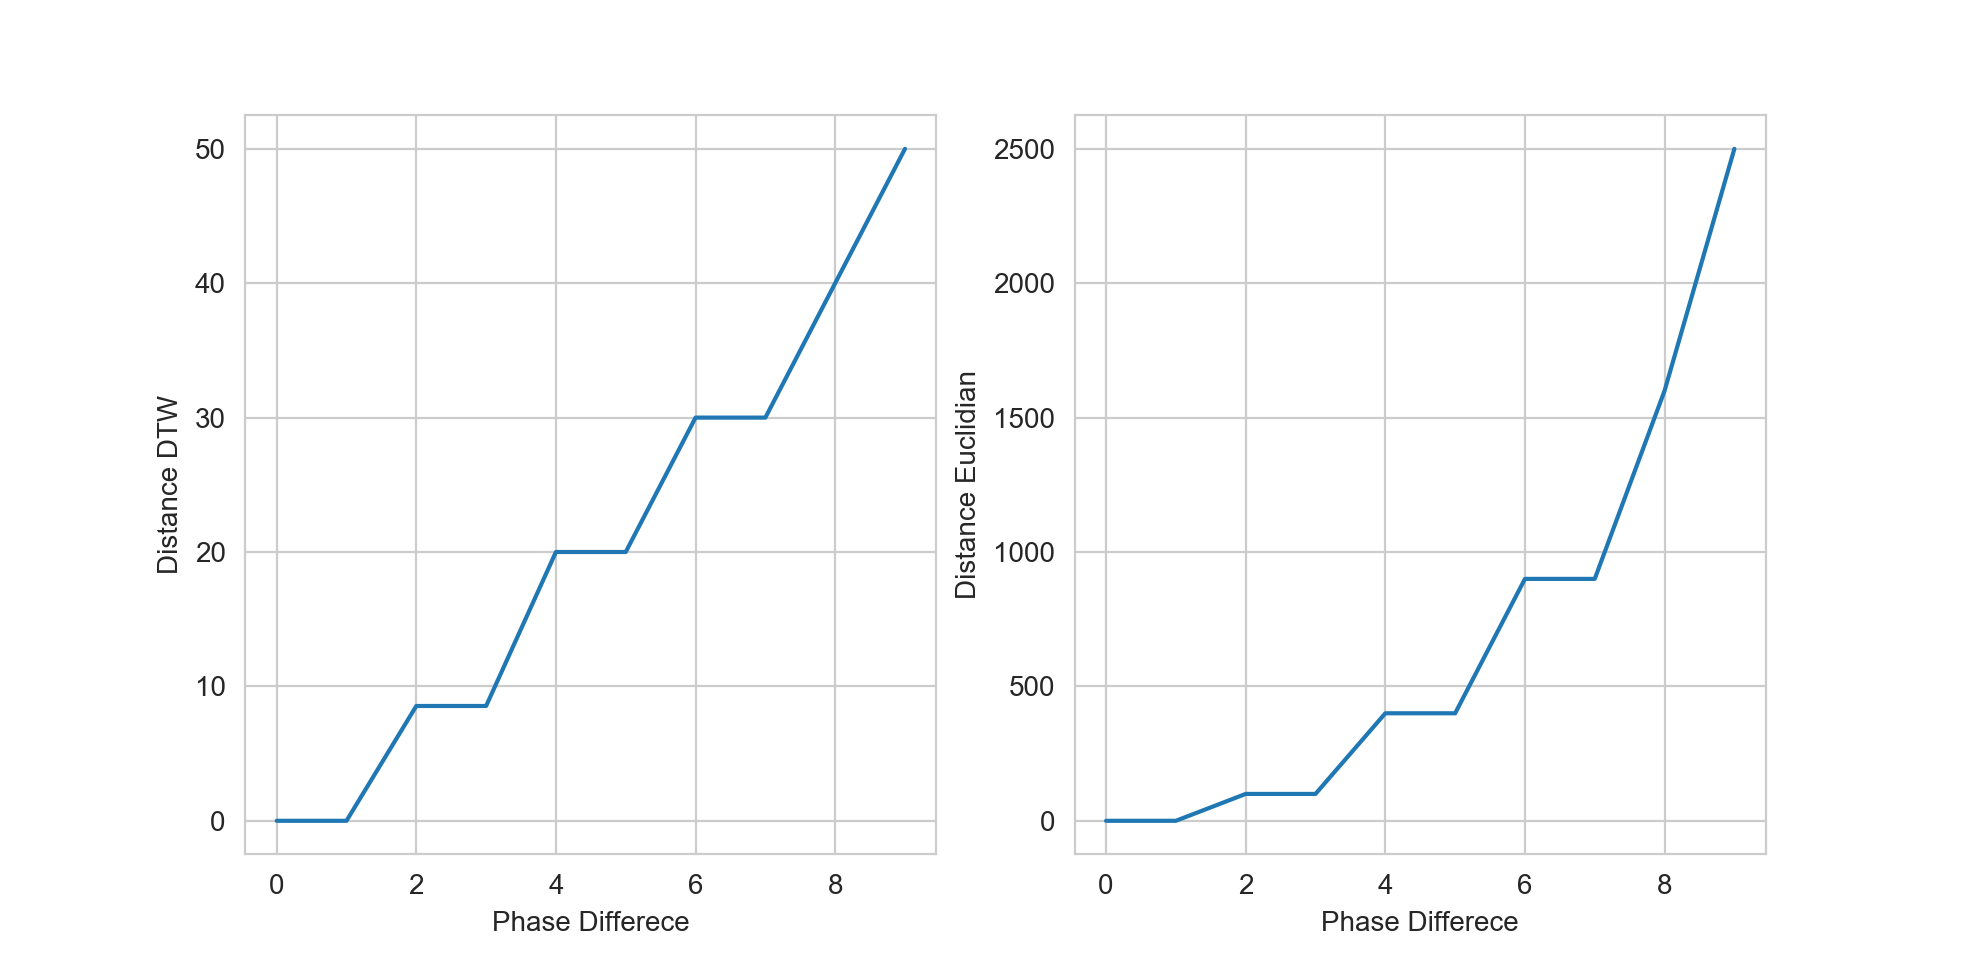

Text(0, 0.5, 'Distance Euclidian')

In [22]:
paths = []
distances_dtw = []
distances_euc = []

for i in sines:
    p, d = ts.dtw_path(sines[0], i)
    paths.append(p)
    distances_dtw.append(d)
    distances_euc.append((sines[0] - i).T @ (sines[0] - i))
    
plt.subplot(1,2,1)
plt.plot(distances_dtw)
plt.xlabel("Phase Differece")
plt.ylabel("Distance DTW")


plt.subplot(1,2,2)
plt.plot(distances_euc)
plt.xlabel("Phase Differece")
plt.ylabel("Distance Euclidian")


But DTW remains robust to the changes in magnitude of the signal

This is useful when we are considering control. For example, when we are peak shaving there is a significant portion of the water that is shifted from the window and we do know the *shape of water*.  

<IPython.core.display.Javascript object>


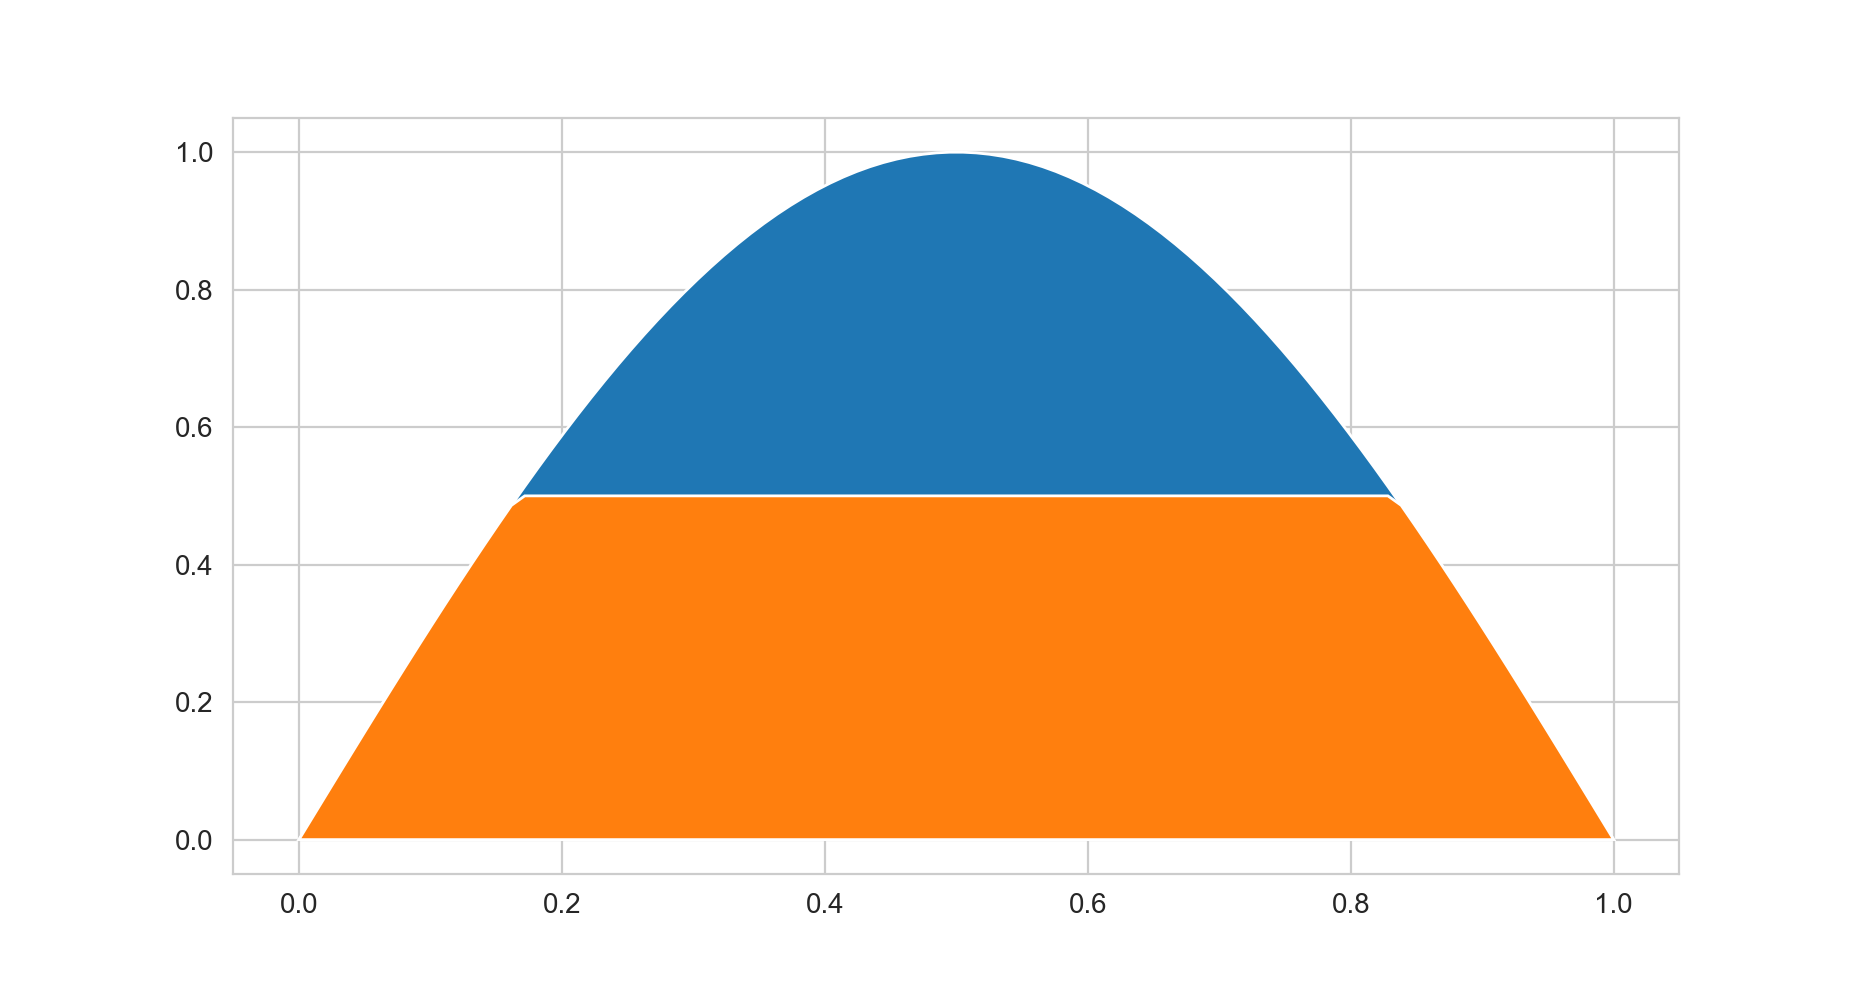

In [23]:
uncontrolled_response = np.sin(np.linspace(0, 1.0, 100)*np.pi)
response1 = copy.deepcopy(uncontrolled_response)
response1[response1 > 0.5] = 0.5
fig, ax = plt.subplots()

ax.fill(np.linspace(0, 1.0, 100), uncontrolled_response)
ax.fill(np.linspace(0, 1.0, 100), response1)

If shave the peak, the shaded water has to be shifted. But which form will it take ?

<IPython.core.display.Javascript object>


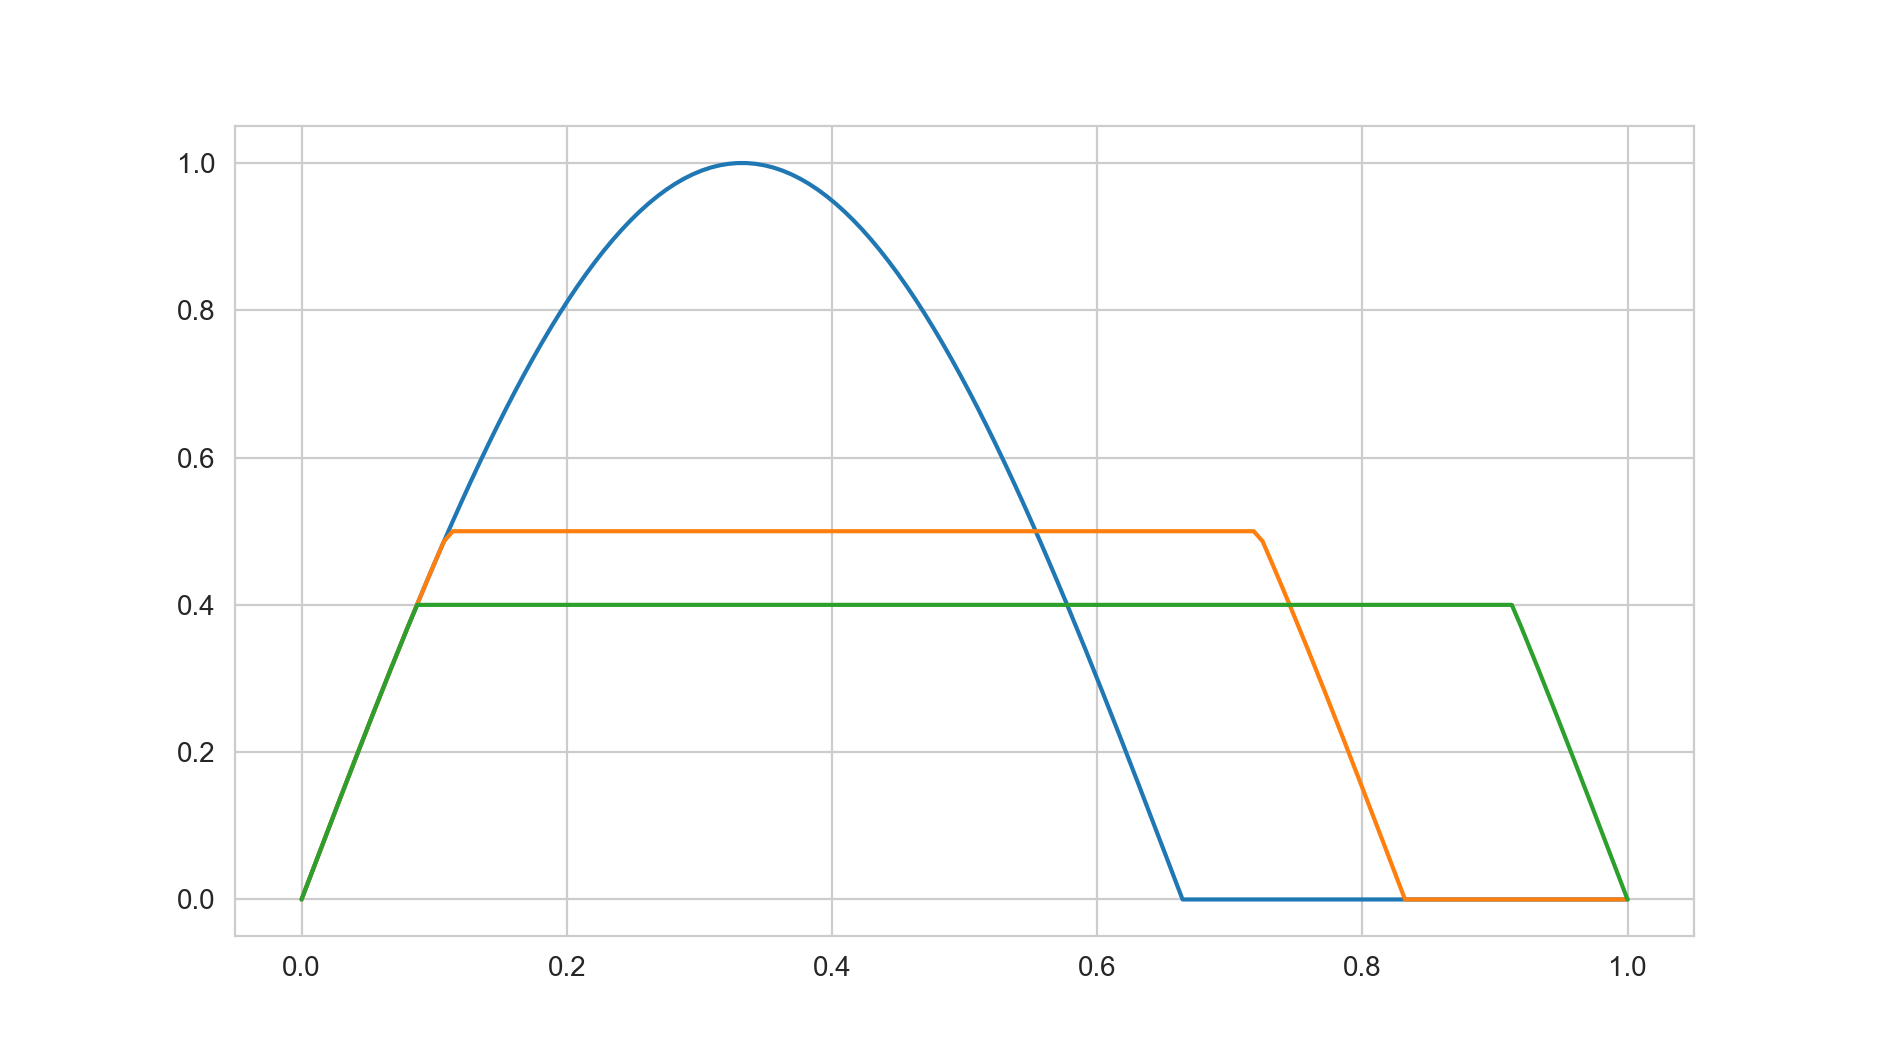

In [24]:
uncontrolled_response = np.hstack((np.sin(np.linspace(0, 1.0, 100)*np.pi), np.zeros(50)))
response1 = copy.deepcopy(uncontrolled_response)
response2 = copy.deepcopy(uncontrolled_response)
response1[response1 > 0.5] = 0.5
response2[response2 > 0.4] = 0.4
response1 = np.hstack((response1[0:25], np.ones(75)*0.5, response1[75:100],np.zeros(25)))
response2 = np.hstack((response2[0:25], np.ones(100)*0.4, response2[75:100],np.zeros(0)))
fig, ax = plt.subplots()

ax.plot(np.linspace(0, 1.0, 150), uncontrolled_response)
ax.plot(np.linspace(0, 1.0, 150), response1)
ax.plot(np.linspace(0, 1.0, 150), response2)

<IPython.core.display.Javascript object>


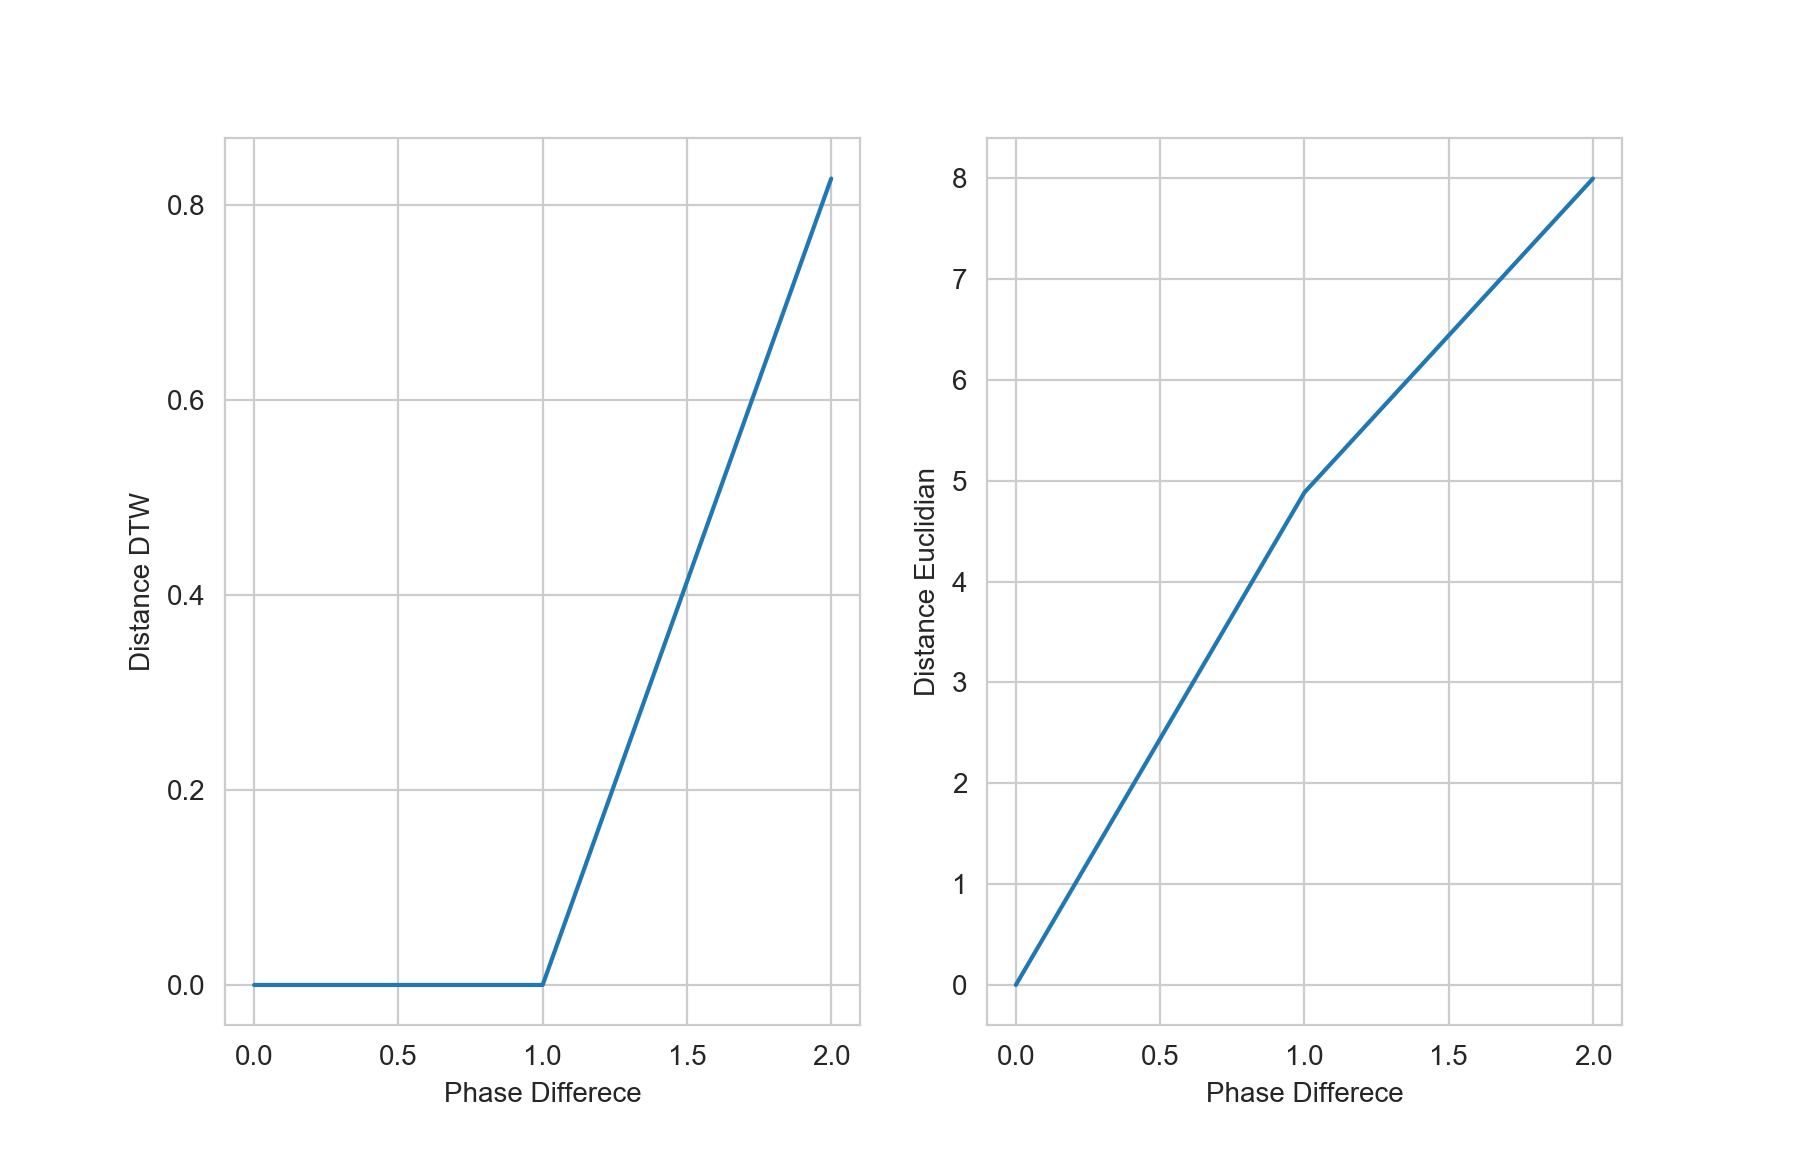

Text(0, 0.5, 'Distance Euclidian')

In [25]:
paths = []
distances_dtw = []
distances_euc = []
control_resp = copy.deepcopy(uncontrolled_response)
control_resp[control_resp > 0.5] = 0.5
sines = [control_resp, response1, response2]
for i in sines:
    p, d = ts.dtw_path(sines[0], i)
    paths.append(p)
    distances_dtw.append(d)
    distances_euc.append((sines[0] - i).T @ (sines[0] - i))
    
plt.subplot(1,2,1)
plt.plot(distances_dtw)
plt.xlabel("Phase Differece")
plt.ylabel("Distance DTW")


plt.subplot(1,2,2)
plt.plot(distances_euc)
plt.xlabel("Phase Differece")
plt.ylabel("Distance Euclidian")


If you notice, any extension in the time series, DTW considers it to be a similar signal, where ED treats it as an anamoly.

Thus, DTW can be effective for the instances where peak shaving is important. 

## Controlling AA

In [26]:
NODES_LIS = {'93-49743' : 'OR39',
             '93-49868' : 'OR34',
             '93-49919' : 'OR44',
             '93-49921' : 'OR45',
             '93-50074' : 'OR38',
             '93-50076' : 'OR46',
             '93-50077' : 'OR48',
             '93-50081' : 'OR47',
             '93-50225' : 'OR36',
             '93-90357' : 'OR43',
             '93-90358' : 'OR35'}


def run_swmm(valve_set1, valve_set2, valve_set3, valve_set4):
    env = Env("./aa_0360min_025yr.inp")

    data = {}
    data["f1"] = []
    data["f2"] = []
    data["f3"] = []
    data["f4"] = []
    data["overflow1"]  = []
    data["overflow2"]  = []
    data["overflow3"]  = []
    data["overflow4"]  = []
    done = False
    for i in range(0, 35000):
        # set the gate_position 
        env.set_gate(NODES_LIS["93-50077"], valve_set1)
        env.set_gate(NODES_LIS["93-50076"], valve_set2)
        env.set_gate(NODES_LIS["93-50081"], valve_set3)
        env.set_gate(NODES_LIS["93-49921"], valve_set4)
        
        # record_data
        data["f1"].append(env.flow(NODES_LIS["93-50077"]))
        data["f2"].append(env.flow(NODES_LIS["93-50076"]))
        data["f4"].append(env.flow(NODES_LIS["93-49921"]))
        data["f3"].append(env.flow(NODES_LIS["93-50081"]))
        
        data["overflow1"].append(env.sim._model.getNodeResult("93-50077", 4))
        data["overflow2"].append(env.sim._model.getNodeResult("93-50076", 4))
        data["overflow4"].append(env.sim._model.getNodeResult("93-49921", 4))
        data["overflow3"].append(env.sim._model.getNodeResult("93-50081", 4))
        
        # step through simulation
        done = env.step()
        
    overflows = {}
    overflows["o1"] = sum(data["overflow1"])
    overflows["o2"] = sum(data["overflow2"])
    overflows["o3"] = sum(data["overflow3"])
    overflows["o4"] = sum(data["overflow4"])
    
    env.sim._model.swmm_end()
    env.sim._model.swmm_close()
    return data, overflows

# Plot the uncontrolled reponse 
un_data, un_overflow = run_swmm(1.0, 1.0, 1.0, 1.0)

In [33]:
downstream_target1 = np.asarray(copy.deepcopy(un_data["f1"]))
downstream_target1[downstream_target1 > 4.0] = 4.0
downstream_target1d =  spy.decimate(downstream_target1, 50)

downstream_target2 = np.asarray(copy.deepcopy(un_data["f2"]))
downstream_target2[downstream_target2 > 4.0] = 4.0
downstream_target2d =  spy.decimate(downstream_target2, 50)


downstream_target3 = np.asarray(copy.deepcopy(un_data["f3"]))
downstream_target3[downstream_target3 > 4.0] = 4.0
downstream_target3d =  spy.decimate(downstream_target3, 50)

downstream_target4 = 0.6 * np.asarray(copy.deepcopy(un_data["f4"]))
downstream_target4d =  spy.decimate(downstream_target4, 50)

<IPython.core.display.Javascript object>


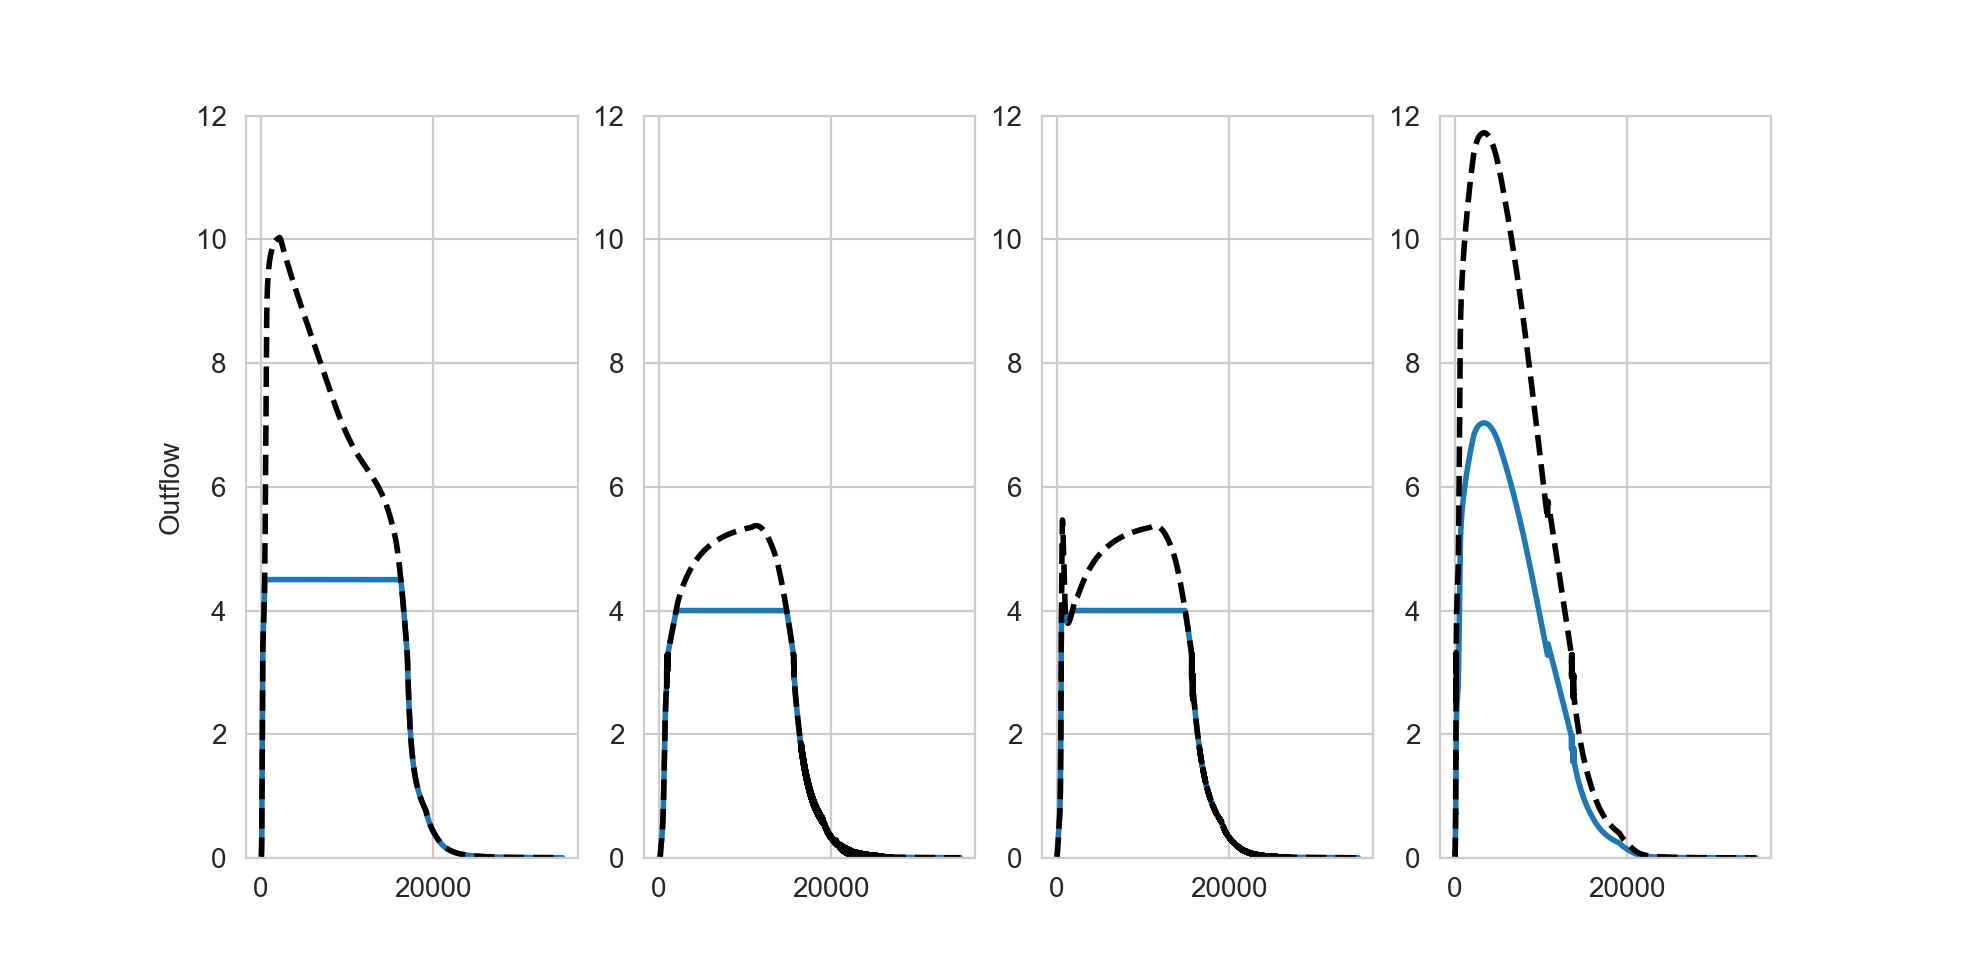

(0, 12)

In [35]:
plt.subplot(1, 4, 1)
plt.plot(downstream_target1, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f1"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow")
plt.ylim([0, 12])

plt.subplot(1, 4, 2)
plt.plot(downstream_target2, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f2"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylim([0, 12])

plt.subplot(1, 4, 3)
plt.plot(downstream_target3, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f3"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylim([0, 12])

plt.subplot(1, 4, 4)
plt.plot(downstream_target4, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f4"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylim([0, 12])

### Create a obj function based on the DTW

In [42]:
def fc(x):
    data, overflow  = run_swmm(x[0][0], x[0][1], x[0][2], x[0][3])
    pred_flow1 = np.asarray(data["f1"])
    pred_flow2 = np.asarray(data["f2"])
    pred_flow3 = np.asarray(data["f3"])
    pred_flow4 = np.asarray(data["f4"])

    pred_flow1 =  spy.decimate(pred_flow1, 50)
    pred_flow2 =  spy.decimate(pred_flow2, 50)
    pred_flow3 =  spy.decimate(pred_flow3, 50)
    pred_flow4 =  spy.decimate(pred_flow4, 50)


    path, distance1 = ts.dtw_path(downstream_target1d,
            pred_flow1,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)

    path, distance2 = ts.dtw_path(downstream_target2d,
            pred_flow2,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)
    
    path, distance3 = ts.dtw_path(downstream_target3d,
            pred_flow3,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)
    
    path, distance4 = ts.dtw_path(downstream_target4d,
            pred_flow4,
            global_constraint="sakoe_chiba",
            sakoe_chiba_radius=1)

    # sum of the outflows
    d = 0.0
    for i in overflow.keys():
        d += overflow[i]
    loss = distance1*10.0 + distance2 + distance3 + distance4*10.0  + (d)*10.0
    print("Distance : {0}, Overflow : {1}".format(distance1 + distance2 + distance3 + distance4, d))
    print("Valve ",x)
    return loss

In [43]:
# Define gpopt
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_2', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_3', 'type': 'continuous', 'domain': (0.0, 1.0)},
          {'name': 'var_4', 'type': 'continuous', 'domain': (0.0, 1.0)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=fc,
        domain=domain,
        model_type = 'GP',
        acquisition_type='EI',
        exact_feval = True,
        acquisition_weight = 4)

myBopt.run_optimization(max_iter=50)

Distance : 151.58735408502187, Overflow : 0.0
Valve  [[0.59991919 0.17505962 0.76130956 0.8421801 ]]
Distance : 212.7939339722936, Overflow : 0.0
Valve  [[0.8584484  0.34879311 0.21747711 0.26410726]]
Distance : 142.79000362041478, Overflow : 0.0
Valve  [[0.6018293  0.40279254 0.74483838 0.68871955]]
Distance : 125.12171692939532, Overflow : 0.0
Valve  [[0.75703583 0.39378398 0.83139859 0.86954241]]
Distance : 141.0890969104122, Overflow : 36139.399234632394
Valve  [[0.69677108 0.51145615 0.08981151 0.88543325]]
Distance : 211.77464327975466, Overflow : 0.0
Valve  [[0.85102188 0.20399701 0.71257241 0.2314058 ]]
Distance : 136.18943610498349, Overflow : 0.0
Valve  [[0.61301263 0.23561983 1.         0.61654695]]
Distance : 300.5605463916693, Overflow : 979.3278670123009
Valve  [[1.         0.12384437 0.22186208 0.        ]]
Distance : 294.8670121736861, Overflow : 984.0411360283306
Valve  [[0.81456147 0.62701049 0.46864365 0.        ]]
Distance : 290.5217024537426, Overflow : 978.7455455

In [44]:
c_data, c_overflow = run_swmm(myBopt.x_opt[0], myBopt.x_opt[1], myBopt.x_opt[2], myBopt.x_opt[3])

<IPython.core.display.Javascript object>


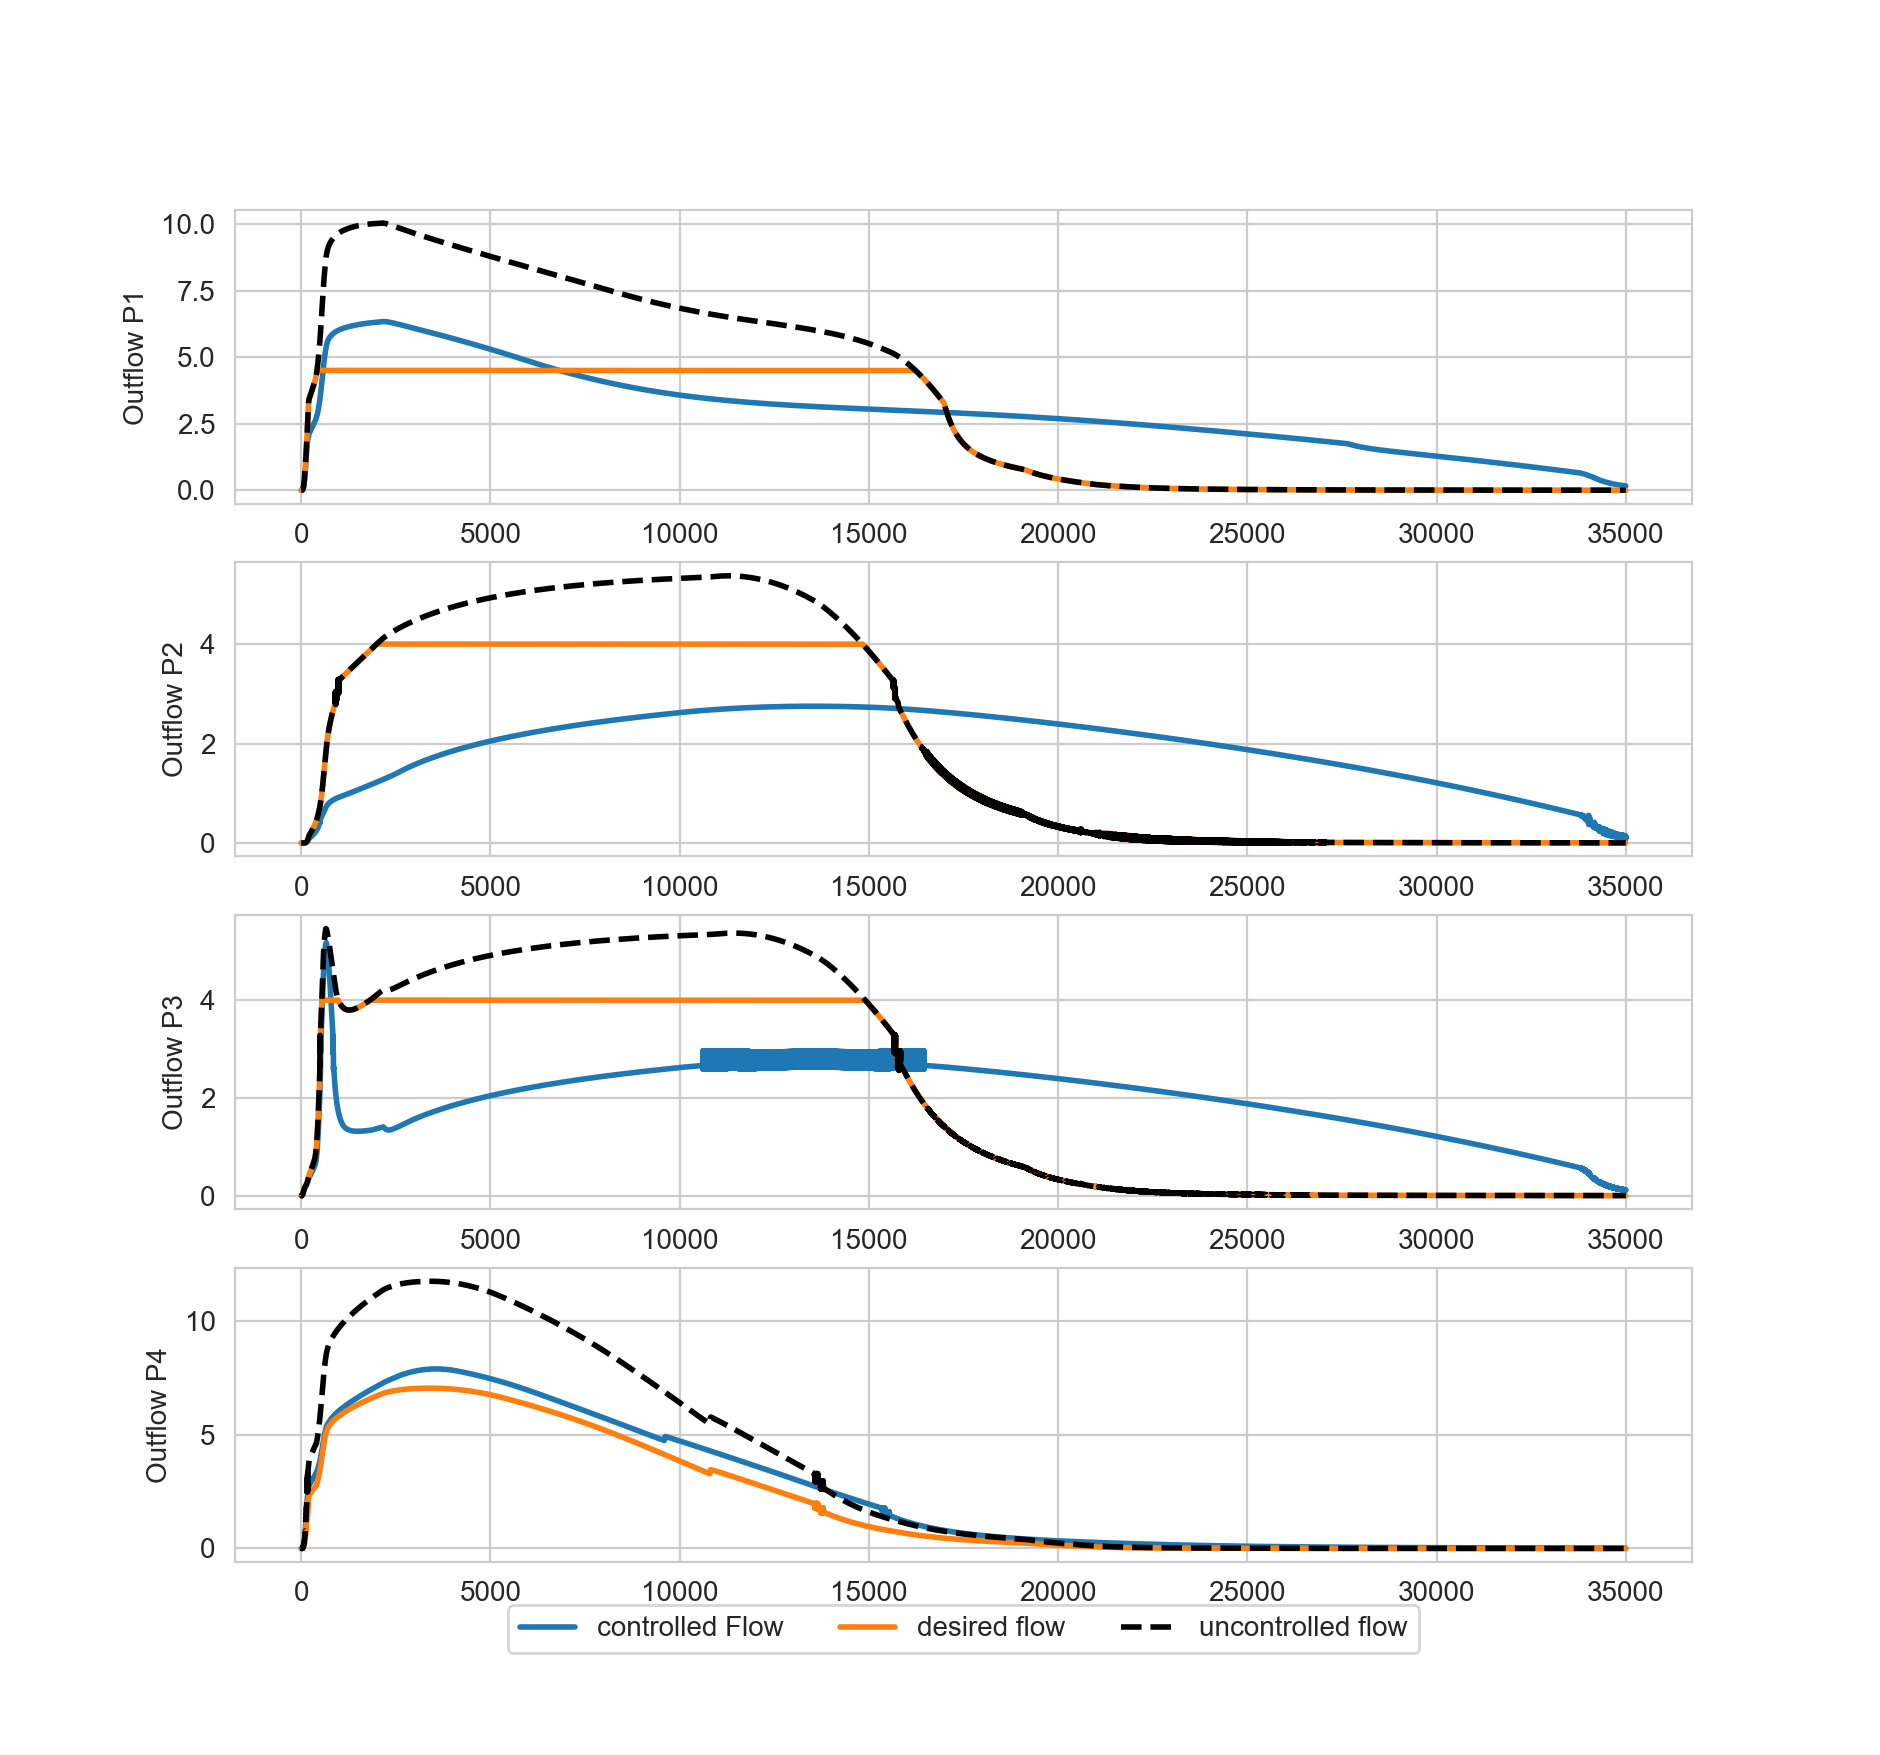

Text(0, 0.5, 'Outflow P4')

In [69]:
plt.subplot(4, 1, 1)
plt.plot(c_data["f1"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target1, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f1"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P1")

plt.subplot(4, 1, 2)
plt.plot(c_data["f2"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target2, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f2"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P2")

plt.subplot(4, 1, 3)
plt.plot(c_data["f3"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target3, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f3"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.ylabel("Outflow P3")

plt.subplot(4, 1, 4)
plt.plot(c_data["f4"], label = "controlled Flow",   linewidth=2.0)
plt.plot(downstream_target4, label = "desired flow", linewidth=2.0)
plt.plot(un_data["f4"], "k--", label = "uncontrolled flow", linewidth=2.0)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.ylabel("Outflow P4")